In [2]:
# Requires transformers>=4.51.0
# gpu visiableble setting
import os
import sys
def set_visible_gpus(gpu_ids):
    """
    Set the visible GPUs for the current process.
    
    Args:
        gpu_ids (str): Comma-separated string of GPU IDs to make visible.
    """
    if not isinstance(gpu_ids, str):
        raise ValueError("gpu_ids must be a string")
    
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_ids
    print(f"CUDA_VISIBLE_DEVICES set to: {gpu_ids}")

set_visible_gpus("0")

CUDA_VISIBLE_DEVICES set to: 0


In [3]:
from deepdow.data import InRAMDataset, RigidDataLoader
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
#from deepdow.layers import ConvNetwork
from deepdow.experiments import Run
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.benchmarks import OneOverN, InverseVolatility, Random, MinimumVariance
from deepdow.callbacks import EarlyStoppingCallback
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from deepdow.utils import raw_to_Xy
from deepdow.benchmarks import Benchmark, OneOverN, Random, MaximumReturn
from deepdow.experiments import Run
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback, Callback
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap

In [4]:
use_aigc_data = True
d_model = 512
configs_dict = {
    'task_name': 'long_term_forecast',
    'features': 'M',  # or 'S' for single variable
    'seq_len': 128,
    'label_len': 0,
    'pred_len': 32,
    'use_norm': True,
    'use_aigc_data': use_aigc_data,  # whether to use AIGC data
    'patch_len': 16,
    'enc_in': (5+1024)*7,  # number of input features
    'd_model': d_model,  # model dimension
    'embed': 'fixed',  # embedding type
    'freq': 'd',  # frequency of the data
    'dropout': 0.2,
    'factor': 4,  # attention factor
    'n_heads': 4,  # number of attention heads
    'd_ff': d_model*4,  # feed-forward dimension
    'e_layers': 12,  # number of encoder layers
    'activation': 'relu',  # activation function
    #'activation': 'silu',
    'augmentation_ratio': 0,  # augmentation ratio
    'seed': 42,  #
    'loss': None,
    'batch_size': 16,  # batch size
    'reduced_channels': 256,
    'n_assets': 7,  # number of assets
}

if use_aigc_data:
    configs_dict['enc_in'] = (5+0)*7
    configs_dict['batch_size'] = 32
else:
    configs_dict['enc_in'] = 5*7


In [5]:
from flask import Config
# 把configs转换为一个类
class Configs:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [6]:
configs = Configs(**configs_dict)

In [7]:
from data_provider.data_loader import Dataset_Custom, custom_collate_fn
from torch.utils.data import Dataset, DataLoader
data_path = 'mag7_ticker_first_returns.parquet'
if use_aigc_data:
    aigc_data_path = 'mag7_aigc_results_embedding_reshaped.parquet'
else:
    aigc_data_path = None
    
train_dataset = Dataset_Custom(
    args=configs,
    root_path='.',
    flag='train',
    size=[configs.seq_len, configs.label_len, configs.pred_len],
    features=configs.features,
    data_path=data_path,
    aigc_data_path=aigc_data_path,
    target='Close',
    scale=False,
    timeenc=1,
    freq='D'
)

val_dataset = Dataset_Custom(
    args=configs,
    root_path='.',
    flag='val',
    size=[configs.seq_len, configs.label_len, configs.pred_len],
    features=configs.features,
    data_path=data_path,
    aigc_data_path=aigc_data_path,
    target='Close',
    scale=False,
    timeenc=1,
    freq='D'
)

test_dataset = Dataset_Custom(
    args=configs,
    root_path='.',
    flag='test',
    size=[configs.seq_len, configs.label_len, configs.pred_len],
    features=configs.features,
    data_path=data_path,
    aigc_data_path=aigc_data_path,
    target='Close',
    scale=False,
    timeenc=1,
    freq='D'
)

train_dataloader = DataLoader(train_dataset, collate_fn=custom_collate_fn, batch_size=configs.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=custom_collate_fn, batch_size=configs.batch_size, shuffle=False)  
test_dataloader = DataLoader(test_dataset, collate_fn=custom_collate_fn, batch_size=configs.batch_size, shuffle=False)

In [8]:
len(test_dataset)

229

In [9]:
for batch in val_dataloader:
    X_batch, y_batch, timestamps_batch, *kw = batch
    print("X shape:", X_batch.shape)
    print("y shape:", y_batch.shape)
    print("Timestamps:", timestamps_batch)
    #print("kw shape:", [k for k in kw])
    break  # 只打印第一个批次

X shape: torch.Size([32, 5, 128, 7])
y shape: torch.Size([32, 5, 32, 7])
Timestamps: [numpy.datetime64('2022-04-06T00:00:00.000000000'), numpy.datetime64('2022-04-07T00:00:00.000000000'), numpy.datetime64('2022-04-08T00:00:00.000000000'), numpy.datetime64('2022-04-11T00:00:00.000000000'), numpy.datetime64('2022-04-12T00:00:00.000000000'), numpy.datetime64('2022-04-13T00:00:00.000000000'), numpy.datetime64('2022-04-14T00:00:00.000000000'), numpy.datetime64('2022-04-18T00:00:00.000000000'), numpy.datetime64('2022-04-19T00:00:00.000000000'), numpy.datetime64('2022-04-20T00:00:00.000000000'), numpy.datetime64('2022-04-21T00:00:00.000000000'), numpy.datetime64('2022-04-22T00:00:00.000000000'), numpy.datetime64('2022-04-25T00:00:00.000000000'), numpy.datetime64('2022-04-26T00:00:00.000000000'), numpy.datetime64('2022-04-27T00:00:00.000000000'), numpy.datetime64('2022-04-28T00:00:00.000000000'), numpy.datetime64('2022-04-29T00:00:00.000000000'), numpy.datetime64('2022-05-02T00:00:00.000000000

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from layers.SelfAttention_Family import FullAttention, AttentionLayer
from layers.Embed import DataEmbedding_inverted, PositionalEmbedding
import numpy as np


class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x


class EnEmbedding(nn.Module):
    def __init__(self, n_vars, d_model, patch_len, dropout):
        super(EnEmbedding, self).__init__()
        # Patching
        self.patch_len = patch_len

        self.value_embedding = nn.Linear(patch_len, d_model, bias=False)
        self.glb_token = nn.Parameter(torch.randn(1, n_vars, 1, d_model))
        self.position_embedding = PositionalEmbedding(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x): # x shape： batch_size, n_channels, n_timesteps
        # do patching
        n_vars = x.shape[1]
        glb = self.glb_token.repeat((x.shape[0], 1, 1, 1))

        x = x.unfold(dimension=-1, size=self.patch_len, step=self.patch_len)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        # Input encoding
        x = self.value_embedding(x) + self.position_embedding(x)
        x = torch.reshape(x, (-1, n_vars, x.shape[-2], x.shape[-1]))
        x = torch.cat([x, glb], dim=2)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        return self.dropout(x), n_vars

class EnEmbedding_multi_channels(nn.Module):
    def __init__(self, n_vars, d_model, patch_len, dropout):
        super(EnEmbedding_multi_channels, self).__init__()
        # Patching
        self.patch_len = patch_len

        self.value_embedding = nn.Linear(patch_len * n_vars, d_model, bias=False)
        self.glb_token = nn.Parameter(torch.randn(1, 1, 1, d_model))
        self.position_embedding = PositionalEmbedding(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x): # x shape： batch_size, n_channels, n_timesteps
        # do patching
        n_vars = 1 #x.shape[1]
        glb = self.glb_token.repeat((x.shape[0], 1, 1, 1))

        x = x.permute(0, 2, 1)
        x = x.unfold(dimension=1, size=self.patch_len, step=self.patch_len)
        x = torch.reshape(x, (x.shape[0], x.shape[1], x.shape[2]*x.shape[3]))
        # Input encoding
        x = self.value_embedding(x) + self.position_embedding(x) # x: B, N, n_vars * patch_len -> B, N, d_model
        x = torch.reshape(x, (-1, n_vars, x.shape[-2], x.shape[-1]))
        x = torch.cat([x, glb], dim=2)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        #n_vars = 1
        return self.dropout(x), n_vars

class Encoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        #self.activation = F.relu if activation == "relu" elif activation == "silu" else F.gelu
        if activation == "relu":
            self.activation = F.relu
        elif activation == "silu":
            self.activation = F.silu  # PyTorch 中 SiLU 对应 F.silu
        else:
            self.activation = F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        B, L, D = cross.shape
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x_glb_ori = x[:, -1, :].unsqueeze(1)
        x_glb = torch.reshape(x_glb_ori, (B, -1, D))
        x_glb_attn = self.dropout(self.cross_attention(
            x_glb, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])
        x_glb_attn = torch.reshape(x_glb_attn,
                                   (x_glb_attn.shape[0] * x_glb_attn.shape[1], x_glb_attn.shape[2])).unsqueeze(1)
        x_glb = x_glb_ori + x_glb_attn
        x_glb = self.norm2(x_glb)

        y = x = torch.cat([x[:, :-1, :], x_glb], dim=1)

        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Model(nn.Module, Benchmark):

    def __init__(self, configs: Configs):
        super(Model, self).__init__()
        self.task_name = configs.task_name
        self.features = configs.features
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.use_norm = configs.use_norm
        self.patch_len = configs.patch_len
        self.patch_num = int(configs.seq_len // configs.patch_len)
        self.n_vars = 1 if configs.features == 'MS' else configs.enc_in
        self.use_aigc_data = configs.use_aigc_data
        self.n_assets = configs.n_assets if hasattr(configs, 'n_assets') else 7  # 默认7个资产
        
        self.aigc_weight = nn.Parameter(torch.tensor(1.0))  # 初始化为 1.0，可根据需要调整
        # 新增：降维后的通道数
        self.reduced_channels = configs.reduced_channels if hasattr(configs, 'reduced_channels') else 1024#configs.n_channels // 2  # 默认减半
        # 新增：降维线性层
        self.channel_reduction = nn.Linear(configs.enc_in//7, self.reduced_channels)
        
        # Embedding
        self.en_embedding = EnEmbedding(self.n_vars, configs.d_model, self.patch_len, configs.dropout)
        self.en_embedding_channels = EnEmbedding_multi_channels(self.n_vars, configs.d_model, self.patch_len, configs.dropout)
        
        self.ex_embedding = DataEmbedding_inverted(configs.seq_len, configs.d_model, configs.embed, configs.freq,
                                                   configs.dropout)

        self.en_aigc_embedding = nn.Linear(1024 * 7, self.n_vars)
        self.aigc_dropout = nn.Dropout(configs.dropout)
        
        self.cross_aigc_embedding = nn.Linear(1024 * 7, configs.d_model)
        self.aigc_cross_dropout = nn.Dropout(configs.dropout)
        # Encoder-only architecture
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=False),
                        configs.d_model, configs.n_heads),
                    AttentionLayer(
                        FullAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        self.head_nf = configs.d_model * (self.patch_num + 1)
        self.head = FlattenHead(self.n_vars, self.head_nf, configs.pred_len,
                                head_dropout=configs.dropout)
        
        # layer to map dec_out to weights shape is        # [batch_size, n_assets]
        self.weight_dropout = nn.Dropout(configs.dropout)
        self.weight_mapping = nn.Linear(self.n_vars * configs.pred_len, 7)
        # use softmax allocator to convert weights to allocations
        self.allocator = SoftmaxAllocator(temperature=1) #formulation='variational', n_assets=7)#, max_weight=0.5, n_assets=7)

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        _, _, N = x_enc.shape

        en_embed, n_vars = self.en_embedding(x_enc[:, :, -1].unsqueeze(-1).permute(0, 2, 1))
        ex_embed = self.ex_embedding(x_enc[:, :, :-1], x_mark_enc)
        


        enc_out = self.encoder(en_embed, ex_embed)
        enc_out = torch.reshape(
            enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        # z: [bs x nvars x d_model x patch_num]
        enc_out = enc_out.permute(0, 1, 3, 2)

        dec_out = self.head(enc_out)  # z: [bs x nvars x target_window]
        dec_out = dec_out.permute(0, 2, 1)

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, -1:].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, -1:].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out


    def forecast_multi(self, x_enc, x_mark_enc, x_dec, x_mark_dec, x_aigc): # x_enc: [n_samples, seq_len, n_assets*n_channels] 
        if self.use_norm:
            # Normalization from Non-stationary Transformer
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc = x_enc / stdev

        _, _, N = x_enc.shape

        if x_aigc is not None and False:
            en_aigc_embed = self.en_aigc_embedding(x_aigc)
            #en_aigc_embed = en_aigc_embed.reshape(x_aigc.shape[0],x_aigc.shape[1], -1)
            en_aigc_embed = self.aigc_dropout(en_aigc_embed)
            
            x_enc = x_enc + self.aigc_weight * en_aigc_embed
        
        en_embed, n_vars = self.en_embedding_channels(x_enc.permute(0, 2, 1))
        
        ex_embed = self.ex_embedding(x_enc, x_mark_enc)
        
        enc_out = self.encoder(en_embed, ex_embed)
        enc_out = torch.reshape(
            enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        # z: [bs x nvars x d_model x patch_num]
        enc_out = enc_out.permute(0, 1, 3, 2)

        dec_out = self.head(enc_out)  # z: [bs x nvars x target_window]
        dec_out = dec_out.permute(0, 2, 1)

        if self.use_norm:
            # De-Normalization from Non-stationary Transformer
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))

        return dec_out

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        if self.use_aigc_data:
            (n_samples, n_channels, lookback, n_assets) = x_enc.shape
            x_aigc_data = x_mark_enc[:, :, 3:]
            #x_mark_enc = x_mark_enc[:, :, :3]  # 保留前3个通道
        else:
            (n_samples, n_channels, lookback, n_assets) = x_enc.shape
        # 新增：对 n_channels 进行降维
        # x_enc = x_enc.permute(0, 2, 3, 1)  # [n_samples, lookback, n_assets, n_channels]
        # x_enc = self.channel_reduction(x_enc)  # [n_samples, lookback, n_assets, reduced_channels]
        # x_enc = x_enc.permute(0, 3, 1, 2)  # [n_samples, reduced_channels, lookback, n_assets]
        # 更新形状
        x_enc = x_enc.permute(0, 2, 3, 1).reshape(n_samples, lookback, n_assets * n_channels)
        (n_samples, lookback, n_mark) = x_mark_enc.shape
        if self.task_name == 'long_term_forecast' or self.task_name == 'short_term_forecast':
            if self.features == 'M':
                dec_out = self.forecast_multi(x_enc, x_mark_enc, x_dec, x_mark_dec, x_aigc_data)
                y_pred = dec_out
                dec_out = self.weight_dropout(dec_out)
                weight_out = self.weight_mapping(dec_out[:, -self.pred_len:, :].reshape(n_samples, -1))  # [B, L, D] -> [B, L * D]
                #return dec_out[:, -self.pred_len:, :]  # [B, L, D]
                y_pred = y_pred.reshape(n_samples, self.pred_len, n_assets, n_channels).permute(0,3,1,2)  # [B, L, D] -> [B, L, D]
                
                weights = self.allocator(weight_out)  # [B, L, D] -> [B, L, D]
                return weights, y_pred
            else:
                dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
                return dec_out[:, -self.pred_len:, :]  # [B, L, D]
        else:
            return None

In [11]:
network = Model(configs)

In [12]:
#loss = MaximumDrawdown(input_type='simple') + 10 * MeanReturns(input_type='simple') +  SharpeRatio(input_type='simple', rf=0.000) #+ my_loss
loss = 10*MeanReturns(input_type='simple') + SharpeRatio(input_type='simple', rf=0.000)
configs.loss = str(loss)


In [13]:
def mse_loss(y_pred, y_true):
    """
    Calculate Mean Squared Error (MSE) loss.
    
    Args:
        y_pred (torch.tensor): Predicted values, shape (batch_size, pred_len, n_assets)
        y_true (torch.tensor): True values, shape (batch_size, pred_len, n_assets)
    
    Returns:
        float: MSE loss
    """
    squared_diff = (y_pred - y_true) ** 2
    mse = torch.mean(squared_diff)
    #mse = torch.sum(squared_diff)
    return mse

In [14]:
import time
from deepdow.experiments import Run, SolverError, EarlyStoppingException
from numpy import NaN

class ExtendedRun(Run):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 初始化可训练的损失权重参数，初始值为5.0
        # self.loss_weight = torch.nn.Parameter(torch.tensor(5.0, dtype=self.dtype, device=self.device), requires_grad=True)
        # self.optimizer.add_param_group({"params": [self.loss_weight]})

    def launch(self, n_epochs=1):
        try:
            self.network.to(device=self.device, dtype=self.dtype)
            if self.current_epoch == -1:
                self.on_train_begin(metadata={"n_epochs": n_epochs})

            for _ in range(n_epochs):
                self.current_epoch += 1
                self.on_epoch_begin(metadata={"epoch": self.current_epoch})

                for batch_ix, batch in enumerate(self.train_dataloader):
                    # 解包以支持额外变量
                    X_batch, y_batch, timestamps, asset_names, *extra = batch
                    extra_data = extra[0] if extra else None  # 处理无额外数据的情况

                    self.on_batch_begin(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                            "extra_data": extra_data,
                        }
                    )

                    X_batch, y_batch = X_batch.to(self.device).to(self.dtype), y_batch.to(self.device).to(self.dtype)
                    extra = [d.to(self.device).to(self.dtype) if isinstance(d, torch.Tensor) else d for d in extra]

                    # if extra_data is not None:
                    #     extra_data = extra_data.to(self.device).to(self.dtype)

                    self.network.train()
                    
                    X_mark = extra[0]
                    y_mark = extra[1] if len(extra) > 1 else None
                    weights, y_pred = self.network(X_batch, X_mark, y_batch, y_mark)
                    
                    y_true = y_batch[:,0,:,:]
                    #y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], 7, -1)[:,:,:,0]  # [batch_size, pred_len, n_assets]
                    y_pred = y_pred[:,0,:,:]
                    # 如果支持，将 extra_data 传递给损失函数
                    y_true = y_true[:, -configs.pred_len:, :]
                    loss_2 = mse_loss(y_pred, y_true)
                    loss_per_sample = self.loss(weights, y_batch[:,:,-configs.pred_len:, :]) 
                    loss = loss_per_sample.mean() / 10 + 10 * loss_2
                    if torch.isnan(loss):
                        print("NaN loss encountered. Skipping this batch.")
                    #print("loss_weight is {}".format(self.loss_weight.item()))
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    self.network.eval()

                    self.on_batch_end(
                        metadata={
                            "asset_names": asset_names,
                            "batch": batch_ix,
                            "batch_loss": loss.item(),
                            "epoch": self.current_epoch,
                            "timestamps": timestamps,
                            "weights": weights,
                            "X_batch": X_batch,
                            "y_batch": y_batch,
                            "extra_data": extra_data,
                        }
                    )

                self.on_epoch_end(
                    metadata={
                        "epoch": self.current_epoch,
                        "n_epochs": n_epochs,
                    }
                )

            self.on_train_end()

        except (EarlyStoppingException, KeyboardInterrupt, SolverError) as ex:
            print("训练中断")
            time.sleep(1)
            self.on_train_interrupt(metadata={"exception": ex, "locals": locals()})

        return self.history

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model = configs.d_model
n_heads = configs.n_heads
n_layers = configs.e_layers

In [16]:
import pathlib
import sys
import numpy as np
import torch
from collections import deque

class ModelCheckpointTop3Callback(Callback):
    """Model checkpointing callback that saves models with metrics better than any of the top 3 smallest metrics.

    Parameters
    ----------
    folder_path : str or pathlib.Path
        Directory to which to save the checkpoints.

    dataloader_name : str
        Name of the dataloader, needs to correspond to a key in `val_dataloaders` in ``deepdow.experiments.Run``.

    metric_name : str
        Name of the metric to use (the lower the better), needs to correspond to a key in `metrics` in
        ``deepdow.experiments.Run``.

    verbose : bool
        If True, each checkpointing triggers a message.

    Attributes
    ----------
    top3_mins : deque
        A deque containing up to three smallest metric values seen so far.
    """

    def __init__(
        self, folder_path, dataloader_name, metric_name, verbose=False
    ):
        self.folder_path = pathlib.Path(folder_path)
        if self.folder_path.is_file():
            raise NotADirectoryError(
                "The checkpointing path needs to be a folder."
            )

        self.dataloader_name = dataloader_name
        self.metric_name = metric_name
        self.verbose = verbose

        self.top3_mins = deque(maxlen=3)  # Store up to 3 smallest metrics
        self.run = None  # will be injected with an instance of ``Run``.

    def on_train_begin(self, metadata):
        """Check if dataloader name and metric name even exist."""
        self.folder_path.mkdir(parents=True, exist_ok=True)

        if self.dataloader_name not in self.run.val_dataloaders:
            raise ValueError(
                "Did not find the dataloader {}".format(self.dataloader_name)
            )

        if self.metric_name not in self.run.metrics:
            raise ValueError(
                "Did not find the metric {}".format(self.metric_name)
            )

    def on_epoch_end(self, metadata):
        """Store checkpoint if metric is smaller than any of the top 3 smallest metrics."""
        epoch = metadata["epoch"]
        stats = self.run.history.metrics_per_epoch(epoch)

        if not (
            len(stats["lookback"].unique()) == 1
            and len(stats["model"].unique()) == 1
        ):
            raise ValueError(
                "ModelCheckpointCallback needs to have a single lookback and model"
            )  # pragma: no cover

        stats_formatted = (
            stats.groupby(["dataloader", "metric"])["value"].mean().unstack(-1)
        )
        current_metric = stats_formatted.loc[
            self.dataloader_name, self.metric_name
        ]

        # If fewer than 3 metrics or current metric is smaller than the largest in top3_mins
        if len(self.top3_mins) < 3 or (self.top3_mins and current_metric < max(self.top3_mins)):
            self.top3_mins.append(current_metric)
            
            checkpoint_path = (
                self.folder_path
                / "model_{:02d}__{:.4f}.pth".format(epoch, current_metric)
            )
            torch.save(self.run.network, str(checkpoint_path))

            if self.verbose:
                print("Checkpointed {}".format(checkpoint_path))

In [17]:
#获得时间 作为文件名
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S")
run = ExtendedRun(network,
          loss,
          train_dataloader,
          benchmarks={'OneOverN': OneOverN(),
                      'MaximumReturn': MaximumReturn(),
                     },
          val_dataloaders={'val': val_dataloader},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.001),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='val',
                                           patience=15),
                     ModelCheckpointTop3Callback(folder_path=f'./models/{date_time}_d_model_{d_model}_nhead{n_heads}_num_layers{n_layers}/',
                                             dataloader_name='val',
                                             metric_name='loss')],
          device=device,
          #dtype=torch.float64,
          )

#

In [22]:
#torch.autograd.set_detect_anomaly(True)
history = run.launch(30)

Epoch 1:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 30: 100%|██████████| 61/61 [01:06<00:00,  1.10s/it, loss=-0.16743, val_loss=-0.02606]


In [19]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model          epoch
val         loss    MaximumReturn  -1       229
                    OneOverN       -1       229
                    network         0       229
Name: value, dtype: int64
dataloader  metric  model          epoch
val         loss    MaximumReturn  -1      -0.036
                    OneOverN       -1      -0.014
                    network         0      -0.008
Name: value, dtype: float32


<Axes: xlabel='epoch'>

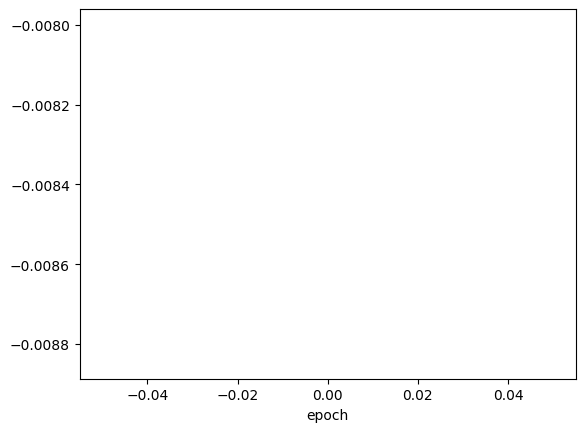

In [20]:
per_epoch_results.mean()['val']['loss']['network'].plot()

In [23]:
from json import load
import os
import glob
from pathlib import Path

def get_latest_pth_file(model_path):
    # 获取目录下所有.pth文件
    pth_files = glob.glob(os.path.join(model_path, "*.pth"))
    
    if not pth_files:
        return None  # 目录下没有.pth文件
    
    # 按修改时间排序，获取最新文件
    latest_file = max(pth_files, key=os.path.getmtime)
    return latest_file

# get file name match pattern in directory

model_path = f'./models/{date_time}_d_model_{d_model}_nhead{n_heads}_num_layers{n_layers}/'

#save configs to file in model_path
with open(os.path.join(model_path, 'configs.json'), 'w') as f:
    import json
    json.dump(configs.__dict__, f, indent=4)
    
#获得model_path下日期最新的文件,文件后缀是pth
best_model_file = get_latest_pth_file(model_path) #model_path + sorted(os.listdir(model_path), key=lambda x: os.path.getmtime(os.path.join(model_path, x)), reverse=True)[0]

pattern = 'model_29*'
best_model_file = glob.glob(os.path.join(model_path, pattern))[0]
print(f'best model file: {best_model_file}')

loaded_network = torch.load(best_model_file, weights_only=False)
loaded_network.to('cpu')
loaded_network.eval()

best model file: ./models/2025-06-22 17-34-50_d_model_512_nhead4_num_layers12/model_29__-0.0270.pth


Model(
  (channel_reduction): Linear(in_features=5, out_features=256, bias=True)
  (en_embedding): EnEmbedding(
    (value_embedding): Linear(in_features=16, out_features=512, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (en_embedding_channels): EnEmbedding_multi_channels(
    (value_embedding): Linear(in_features=560, out_features=512, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (ex_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (en_aigc_embedding): Linear(in_features=7168, out_features=35, bias=True)
  (aigc_dropout): Dropout(p=0.2, inplace=False)
  (cross_aigc_embedding): Linear(in_features=7168, out_features=512, bias=True)
  (aigc_cross_dropout): Dropout(p=0.2, inplace=False)
  (encoder): Encoder(
    (layers): ModuleList(
      (0-11):

In [24]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    #'MaximumReturn': MaximumReturn(),  # random allocation that is however close 1OverN
    #'network': network,
    'best_network': loaded_network
}

In [25]:
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
    'MeanReturn': MeanReturns()
}

In [26]:
metrics_table = generate_metrics_table(benchmarks,
                                       val_dataloader,
                                       metrics,
                                       device='cpu')

In [27]:
Metric = ['MaxDD', 'MeanReturn', 'Sharpe']
i = 1
value_1 = metrics_table[(metrics_table['metric'] == Metric[i]) & (metrics_table['benchmark'] == '1overN')][['value','timestamp']].sort_values('timestamp')['value']
value_2 = metrics_table[(metrics_table['metric'] == Metric[i]) & (metrics_table['benchmark'] == 'best_network')][['value','timestamp']].sort_values('timestamp')['value']
print(f'best_network: {value_2.mean()}, 1overN: {value_1.mean()}')
if value_2.mean() < value_1.mean():
    print('best_network is better than 1overN')
else:
    print('1overN is better than best_network')

best_network: -0.0008703265339136124, 1overN: -0.0006679756916128099
best_network is better than 1overN


Text(0.5, 1.0, 'MeanReturn Comparison')

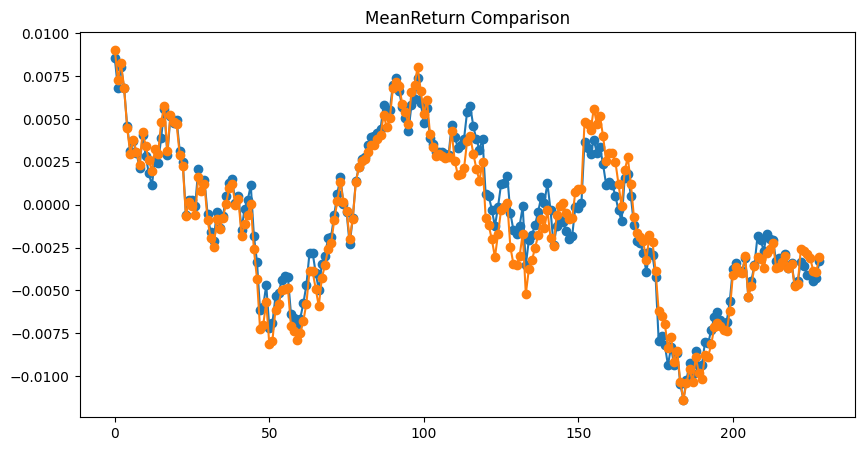

In [28]:
#plot value_1, value_2 in one plot
plt.figure(figsize=(10, 5))
plt.plot(value_1.values, label='1OverN Mean Return', marker='o')
plt.plot(value_2.values, label='Best Network Mean Return', marker='o')
plt.title(f'{Metric[i]} Comparison')

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

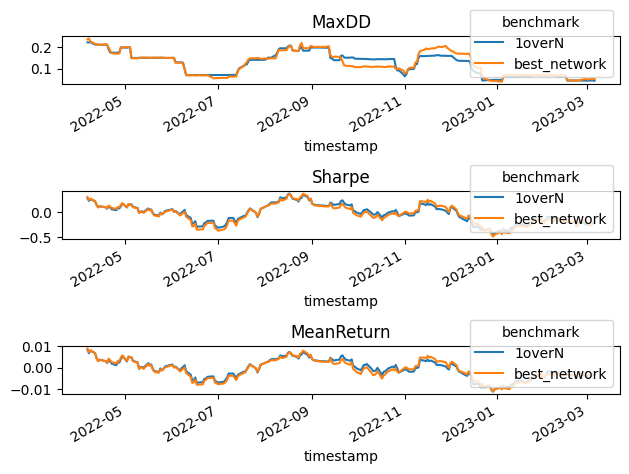

In [29]:
plot_metrics(metrics_table)

In [30]:
weight_table_val = generate_weights_table(loaded_network, val_dataloader,device = 'cpu')

<Axes: >

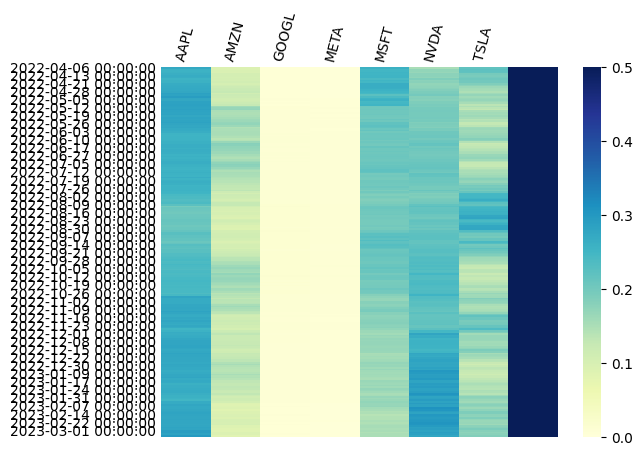

In [31]:
from cycler import V


plot_weight_heatmap(weight_table_val,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=5,
                    vmax=0.5)

In [32]:
metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics,
                                       device='cpu')

In [33]:
Metric = ['MaxDD', 'MeanReturn', 'Sharpe']
i = 1
value_1 = metrics_table[(metrics_table['metric'] == Metric[i]) & (metrics_table['benchmark'] == '1overN')][['value','timestamp']].sort_values('timestamp')['value']
value_2 = metrics_table[(metrics_table['metric'] == Metric[i]) & (metrics_table['benchmark'] == 'best_network')][['value','timestamp']].sort_values('timestamp')['value']
print(f'best_network: {value_2.mean()}, 1overN: {value_1.mean()}')
if value_2.mean() < value_1.mean():
    print('best_network is better than 1overN')
else:
    print('1overN is better than best_network')

best_network: -0.002404352417215705, 1overN: -0.0023021174129098654
best_network is better than 1overN


Text(0.5, 1.0, 'Mean Return Comparison')

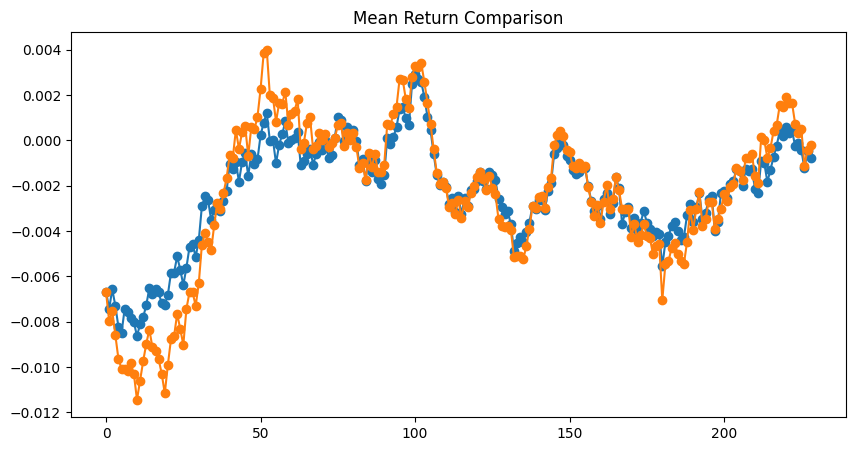

In [34]:
#plot value_1, value_2 in one plot
plt.figure(figsize=(10, 5))
plt.plot(value_1.values, label='1OverN Mean Return', marker='o')
plt.plot(value_2.values, label='Best Network Mean Return', marker='o')
plt.title('Mean Return Comparison')

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>,
       <Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>],
      dtype=object)

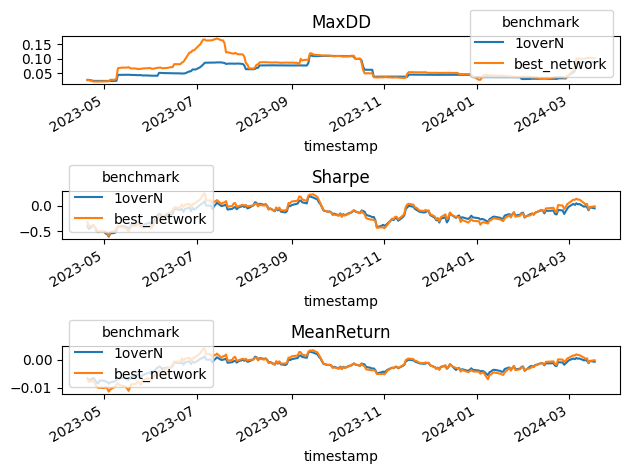

In [35]:
plot_metrics(metrics_table)

In [36]:
weight_table_test = generate_weights_table(loaded_network, test_dataloader,device = 'cpu')

<Axes: >

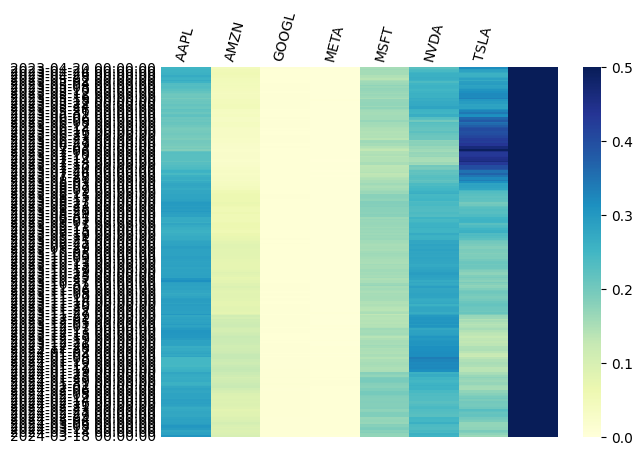

In [37]:
plot_weight_heatmap(weight_table_test,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=2,
                    vmax = 0.5
                    )

In [38]:
weight_table_test

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
2023-04-20,0.250,0.045,0.006,0.003,0.152,0.226,0.318
2023-04-21,0.256,0.051,0.006,0.003,0.159,0.238,0.287
2023-04-24,0.255,0.053,0.006,0.003,0.155,0.244,0.285
2023-04-25,0.257,0.055,0.006,0.003,0.155,0.252,0.272
2023-04-26,0.258,0.057,0.006,0.003,0.156,0.261,0.259
...,...,...,...,...,...,...,...
2024-03-12,0.294,0.094,0.007,0.004,0.190,0.235,0.175
2024-03-13,0.279,0.090,0.008,0.005,0.179,0.246,0.193
2024-03-14,0.283,0.093,0.008,0.005,0.182,0.242,0.187
2024-03-15,0.286,0.095,0.007,0.004,0.174,0.258,0.176


In [39]:
#merge weight_table_val and weight_table_test
import pandas as pd


w = pd.concat([weight_table_val, weight_table_test], axis=0)

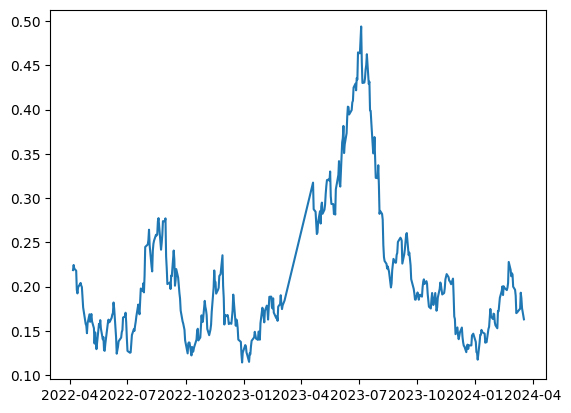

In [40]:
plt.plot(w['TSLA'])